二、动手实现 logistic 回归

In [3]:
#调用torch库
import torch
import torchvision
import torchvision.transforms as transforms
#调用numpy库
import numpy as np
#调用matplotlib库
import matplotlib.pyplot as plt
#调用random库
import random

人工数据集的构造

In [4]:
n_data = torch.ones(50, 2) # 数据的基本形态
x1 = torch.normal(2 * n_data, 1) # shape=(50, 2)
y1 = torch.zeros(50) # 类型0 shape=(50, 1)
x2 = torch.normal(-2 * n_data, 1) # shape=(50, 2)
y2 = torch.ones(50) # 类型1 shape=(50, 1)
# 注意 x, y 数据的数据形式一定要像下面一样 (torch.cat 是合并数据)
features = torch.cat((x1, x2), 0).type(torch.FloatTensor)
labels = torch.cat((y1, y2), 0).type(torch.FloatTensor)

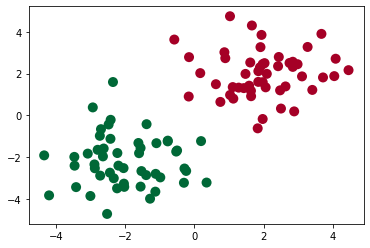

In [5]:
plt.scatter(features.data.numpy()[:, 0], features.data.numpy()[:, 1], c=labels.data.numpy(), s=100, lw=0, 
cmap='RdYlGn')
plt.show()

题目1. 要求动手从0实现 logistic 回归（只借助Tensor和Numpy相关的库）在人工构造的数据集上进
行训练和测试，并从loss以及训练集上的准确率等多个角度对结果进行分析
（可借助nn.BCELoss或nn.BCEWithLogitsLoss作为损失函数，从零实现二元交叉熵为选作）

In [6]:
#使用课上给出的数据读取函数
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices) # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # 最后一次可能不足一个batch
        yield features.index_select(0, j), labels.index_select(0, j)

In [7]:
#使用课上给出的优化函数进行参数的学习优化
def sgd(params, lr, batch_size):
    for param in params:
        param.data -= lr * param.grad / batch_size

In [26]:
# 损失函数使用torch提供的BCELoss, 以及手动实现的二元交叉熵损失
Loss1 = torch.nn.BCELoss()

def Loss2(y_hat, y):
    y_hat = y_hat.unsqueeze(1)
    y_hat = torch.cat((1-y_hat, y_hat), 1)
    return - torch.log(y_hat.gather(1, y.view(-1, 1).to(torch.int64)))

首先使用手动实现的Logistic回归模型进行实验

In [79]:
#手动实现的Logistic回归模型
class Logis:
    def __init__(self, feature_channels, opt):
        self.w = torch.tensor(np.random.normal(0, 0.01, (feature_channels, 1)), dtype=torch.float32)
        self.b = torch.zeros(1, dtype=torch.float32)
        self.w.requires_grad_(requires_grad=True)
        self.b.requires_grad_(requires_grad=True) 
        
        self.opt = opt

    def forward(self, x):
        y_hat = 1/(1 + torch.exp(-(torch.mm(x, self.w) + self.b))).squeeze(1)
        return y_hat

    def learn(self, lr, bs):
        self.opt([self.w, self.b], lr, bs)
        
    def reset_grad(self):
        self.w.grad.data.zero_()
        self.b.grad.data.zero_()

In [63]:
#手动封装准确率计算函数
def evaluate(y_hat, y):
    y_hat = y_hat.unsqueeze(1)
    y_hat = torch.cat((1-y_hat, y_hat), 1)
    y_hat = torch.argmax(y_hat, 1)
    return (len(y_hat) - torch.sum(torch.abs(y_hat-y), dim=0)) / len(y_hat)

In [80]:
lr = 0.03
num_epochs = 100
batch_size = 10
opt = sgd
net = Logis(2, sgd)
loss = Loss2

for epoch in range(num_epochs): # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次
    for X, y in data_iter(batch_size, features, labels): # x和y分别是小批量样本的特征和标签
        l = loss(net.forward(X), y).sum() # l是有关小批量X和y的损失
        l.backward() # 小批量的损失对模型参数求梯度
        net.learn(lr, batch_size)
        net.reset_grad()
        train_l = loss(net.forward(features), labels)
    acc = evaluate(net.forward(features), labels)
    print('epoch %d, acc %f, loss %f' % (epoch + 1, acc.item(), train_l.mean().item()))

epoch 1, acc 1.000000, loss 0.347424
epoch 2, acc 1.000000, loss 0.235070
epoch 3, acc 1.000000, loss 0.180906
epoch 4, acc 1.000000, loss 0.149366
epoch 5, acc 1.000000, loss 0.128336
epoch 6, acc 1.000000, loss 0.113290
epoch 7, acc 1.000000, loss 0.101908
epoch 8, acc 1.000000, loss 0.092994
epoch 9, acc 1.000000, loss 0.085778
epoch 10, acc 1.000000, loss 0.079797
epoch 11, acc 1.000000, loss 0.074758
epoch 12, acc 1.000000, loss 0.070443
epoch 13, acc 1.000000, loss 0.066695
epoch 14, acc 1.000000, loss 0.063414
epoch 15, acc 1.000000, loss 0.060507
epoch 16, acc 1.000000, loss 0.057914
epoch 17, acc 1.000000, loss 0.055579
epoch 18, acc 1.000000, loss 0.053470
epoch 19, acc 1.000000, loss 0.051550
epoch 20, acc 1.000000, loss 0.049795
epoch 21, acc 1.000000, loss 0.048185
epoch 22, acc 1.000000, loss 0.046698
epoch 23, acc 1.000000, loss 0.045322
epoch 24, acc 1.000000, loss 0.044045
epoch 25, acc 1.000000, loss 0.042854
epoch 26, acc 1.000000, loss 0.041742
epoch 27, acc 1.00000

-1.6255441904067993 -1.4737021923065186 -0.04405731335282326


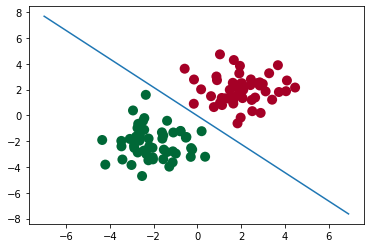

In [81]:
# 结果可视化
w0, w1 = net.w[:]
w0 = w0.item()
w1 = w1.item()
b = net.b.item()
print(w0, w1, b)
plot_x = np.arange(-7, 7, 0.1)
plot_y = (-w0 * plot_x - b) / w1
plt.scatter(features.data.numpy()[:, 0], features.data.numpy()[:, 1], c=labels.data.numpy(), s=100, lw=0, cmap='RdYlGn')
plt.plot(plot_x, plot_y)
plt.show()

其次利用 torch.nn 实现 logistic 回归

In [82]:
#利用torch.nn内部封装的层实现的Logistic回归模型
class Logis(torch.nn.Module):
    def __init__(self, feature_channels):
        super(Logis, self).__init__()
        self.linear = torch.nn.Linear(feature_channels, 1)
        self.active = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x)
        y_hat = self.active(x)
        return y_hat.squeeze(1)

In [83]:
lr = 0.03
num_epochs = 100
batch_size = 10
net = Logis(2)
opt = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)
loss = Loss1

for epoch in range(num_epochs): # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次
    for X, y in data_iter(batch_size, features, labels): # x和y分别是小批量样本的特征和标签
        l = loss(net.forward(X), y).sum() # l是有关小批量X和y的损失
        opt.zero_grad()
        l.backward() # 小批量的损失对模型参数求梯度
        opt.step()
        train_l = loss(net.forward(features), labels)
    acc = evaluate(net.forward(features), labels)
    print('epoch %d, acc %f, loss %f' % (epoch + 1, acc.item(), train_l.mean().item()))

epoch 1, acc 0.990000, loss 0.098498
epoch 2, acc 1.000000, loss 0.043246
epoch 3, acc 1.000000, loss 0.028271
epoch 4, acc 1.000000, loss 0.022309
epoch 5, acc 1.000000, loss 0.019524
epoch 6, acc 1.000000, loss 0.017701
epoch 7, acc 1.000000, loss 0.016405
epoch 8, acc 1.000000, loss 0.015271
epoch 9, acc 1.000000, loss 0.014413
epoch 10, acc 1.000000, loss 0.013683
epoch 11, acc 1.000000, loss 0.013042
epoch 12, acc 1.000000, loss 0.012469
epoch 13, acc 1.000000, loss 0.011935
epoch 14, acc 1.000000, loss 0.011469
epoch 15, acc 1.000000, loss 0.011087
epoch 16, acc 1.000000, loss 0.010749
epoch 17, acc 1.000000, loss 0.010381
epoch 18, acc 1.000000, loss 0.010064
epoch 19, acc 1.000000, loss 0.009752
epoch 20, acc 1.000000, loss 0.009495
epoch 21, acc 1.000000, loss 0.009247
epoch 22, acc 1.000000, loss 0.009011
epoch 23, acc 1.000000, loss 0.008801
epoch 24, acc 1.000000, loss 0.008592
epoch 25, acc 1.000000, loss 0.008394
epoch 26, acc 1.000000, loss 0.008219
epoch 27, acc 1.00000

-2.93290638923645 -2.566174030303955 -0.053373850882053375


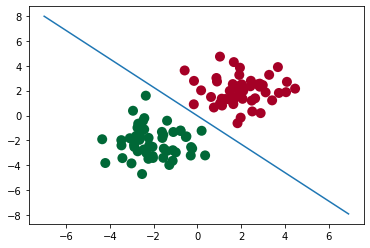

In [85]:
# 结果可视化
w0, w1 = net.linear.weight[0]
w0 = w0.item()
w1 = w1.item()
b = net.linear.bias.item()
print(w0, w1, b)
plot_x = np.arange(-7, 7, 0.1)
plot_y = (-w0 * plot_x - b) / w1
plt.scatter(features.data.numpy()[:, 0], features.data.numpy()[:, 1], c=labels.data.numpy(), s=100, lw=0, cmap='RdYlGn')
plt.plot(plot_x, plot_y)
plt.show()